# UWAGA NOTKA OD PAWLA WCZYTAJCIE SIE DOKLDANIE W MOJ KOD IZAUWAZCIE ZE ZROBIONE SA 3 ROZNE ZBIORY DANYCH- KAZDY MA INNE UZUPELNAINIE BRAKOW- TRZEBA ZORBOIC DLA KAZDEGO OSOBNE WSZYTSKO

# Opracowanie modelu regresyjnego 

Model regresyjny, który na podstawie posiadanego zbioru (zawierającego zmienne ekonomiczne, społeczne i zdrowotne) będzie przewidywać **oczekiwaną długość życia**.

**Przedmiot:** Metody Eksploracji Danych

**Autorzy:** Stanisław Dutkiewicz, Paweł Myszka, Łukasz Jugo

**Grupa 6**

**Data:** 11 stycznia 2026

In [35]:
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, Ridge

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 140)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

sns.set_theme(style="whitegrid")

# 1 Wczytanie CSV i wstępna analiza zbioru


In [36]:
df = pd.read_csv("Life Expectancy Data.csv")

df.columns = df.columns.str.strip()

display(df.info())
display(df.head())

cat_cols = df.select_dtypes(include="object").columns
print("\nKolumny kategoryczne:", cat_cols)
for col in cat_cols:
    print("-", col, ":", df[col].nunique())

print("\nCechy:", list(df.columns))

print("\nPrzykładowe kraje:", pd.Series(df["Country"].unique()).sample(5).values)

print("\nLata:", df["Year"].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10  BMI                              2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

None

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5



Kolumny kategoryczne: Index(['Country', 'Status'], dtype='object')
- Country : 193
- Status : 2

Cechy: ['Country', 'Year', 'Status', 'Life expectancy', 'Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years', 'thinness 5-9 years', 'Income composition of resources', 'Schooling']

Przykładowe kraje: ["Democratic People's Republic of Korea" 'Republic of Korea' 'India'
 'Saint Vincent and the Grenadines' 'Morocco']

Lata: [2015 2014 2013 2012 2011 2010 2009 2008 2007 2006 2005 2004 2003 2002
 2001 2000]


# Wnioski ze wstępnej analizy zbioru po wczydatniu danych z pliku **Life Expectancy Data.csv**.


Nazwy cech: 'Measles ',' BMI ', 'under-five deaths ', 'Diphtheria ',' HIV/AIDS', ' thinness  1-19 years', ' thinness 5-9 years' posiadają białe znaki na skrajach- refaktoryzujemy ich nazwy by się ich pozbyć. 

Przegląd zbioru zbioru:

- **posiadamy 21 cech:** 'Country', 'Year', 'Status', 'Life expectancy', 'Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years', 'thinness 5-9 years', 'Income composition of resources', 'Schooling'

- **Posidamy 2 cechy nie numeryczne** country, które odpowiada za nazwę kraju oraz status, która jest cechą binarną, ponieważ przyjmować może jedynie wartość: Developed lub Developing

- **kraje znajdujące się w zbiorze są z całęgo świata,** a nie tylko z jednego kontynentu,

- **dane są z lat: od 2000 do 2015.**

# 2 Braki danych

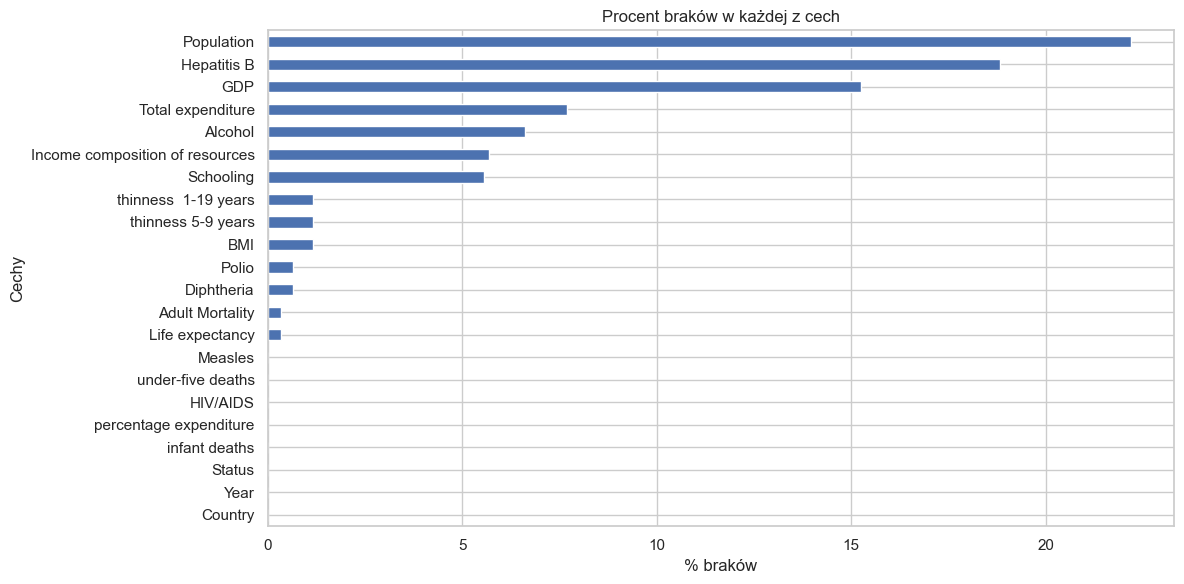


 Life expect missing %: 0.34

 Life expect missing %: 0.0


In [37]:
missing_pct = df.isna().mean() * 100

plt.figure(figsize=(12, 6))
missing_pct.sort_values(ascending=True).plot(kind='barh',)
plt.xlabel('% braków')
plt.ylabel('Cechy')
plt.title('Procent braków w każdej z cech')
plt.tight_layout()
plt.show()

print("\n Life expect missing %:", round(df["Life expectancy"].isna().mean() * 100, 2))

df_clean = df.dropna(subset=["Life expectancy"])
print("\n Life expect missing %:", round(df_clean["Life expectancy"].isna().mean() * 100, 2))

numeric_columns = df_clean.drop(columns=["Country", "Status"]).columns.tolist()

## Braki danych - procentowa analiza

Na podstawie procentowej analizy braków danych w każdej cech określamy:
- największy brak (aż 22.19%) wysepuję dla populacji
- najmniejszy ale najbardziej uciążliwy brak występuję dla naszej zmeinnej objaśnionej Life expectancy- 0,34%.
- cechy kategoryczne nie psoiadają braków

Usunięcie wszystkich wierszy z brakującymi danymi powoduje zbyt dużą stratę informacji, dlatego usuwamy jedynie wiersze gdzie brakuje naszej kluczowej zmiennej- Life expectancy.

Z pozostałymi cechami możemy:
- uzupełnianie w obrębie danego kraju po czasie- zastępowanie braku najbliższą znaną wartością
- uzupełnić braki w kolumnach liczbowych za pomocą mediany
- uzupełenienie za pomocą interpolacji- w obrębie danego kraju na podstawie interpolacji- wartości których nie ma są wybierane na podstawie innnych wartości danego kraju, chyba że nie ma wartości skrajnych wówczas- uruchamiamy dla tych wartości autouzupełnianie.

# Autouzupełnianie

In [38]:
df_filled = df_clean.copy()

df_filled[numeric_columns] = df_filled.groupby("Country")[numeric_columns].ffill().bfill()

# Uzupełnianie za pomocą mediany

In [63]:
df_median = df_clean.copy()

num_imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

df_median[numeric_columns] = num_imputer.fit_transform(df_median[numeric_columns])

# Uzupełnianie za pomocą interpolacji

In [64]:
df_closest_neighbour = df_clean.copy()

df_closest_neighbour[numeric_columns] = df_closest_neighbour.groupby("Country")[numeric_columns]\
    .transform(lambda g: g.interpolate(method='linear'))

df_closest_neighbour[numeric_columns] = df_closest_neighbour.groupby("Country")[numeric_columns].ffill().bfill()

## 3 Wybór zmiennej objaśnionej

Jako zmienną objaśnioną użyliśmy: **Life expectancy**

Z listy pozostałych cech usunęliśmy cechę Country, aby uniknąć sytuacji gdzie model nauczy się rozpoznawać kraję.

Wybieramy zmienne i cechy dla każdego zbioru danych osobno- każdy zbiór danych ma inne uzupełnianie braków

In [65]:
y_median = df_median["Life expectancy"]

x_median = df_median.drop(columns=["Life expectancy", "Country"])

y_closest_neighbour = df_closest_neighbour["Life expectancy"]

x_closest_neighbour = df_closest_neighbour.drop(columns=["Life expectancy", "Country"])

y_filled = df_filled["Life expectancy"]

x_filled = df_filled.drop(columns=["Life expectancy", "Country"])

# 4 Podział na zbiory treningowy i testowy.

In [66]:
x_train_filled, x_test_filled, y_train_filled, y_test_filled = train_test_split(
    x_filled,
    y_filled,
    test_size=0.2,
    random_state=RANDOM_STATE,
    shuffle=True
)

print("Treningowy z autouzupełnianiem:", x_train_filled.shape, "Testowy  z autouzupełnianiem:", x_test_filled.shape)

x_train_closest_neighbour, x_test_closest_neighbour, y_train_closest_neighbour, y_test_closest_neighbour = train_test_split(
    x_closest_neighbour,
    y_closest_neighbour,
    test_size=0.2,
    random_state=RANDOM_STATE,
    shuffle=True
)

print("Treningowy z interpolacją najbliższego sąsiada:", x_train_closest_neighbour.shape, "Testowy z interpolacją najbliższego sąsiada::", x_test_closest_neighbour.shape)

x_train_median, x_test_median, y_train_median, y_test_median = train_test_split(
    x_median,
    y_median,
    test_size=0.2,
    random_state=RANDOM_STATE,
    shuffle=True
)

print("Treningowy z medianą:", x_train_median.shape, "Testowy z medianą:", x_test_median.shape)

Treningowy z autouzupełnianiem: (2342, 20) Testowy  z autouzupełnianiem: (586, 20)
Treningowy z interpolacją najbliższego sąsiada: (2342, 20) Testowy z interpolacją najbliższego sąsiada:: (586, 20)
Treningowy z medianą: (2342, 20) Testowy z medianą: (586, 20)


## 5 Przygotowanie danych

Cecha binarna "Status" została przekształcona w następujący sposób: Developing na 0, a Developed na 1

Po przygotowaniu dane zostały połączone w macierz cech.

In [67]:
def prepare_X_t(x_train: pd.DataFrame, x_test: pd.DataFrame) -> tuple:

    numeric_columns = x_train.select_dtypes(include='number').columns.tolist()

    X_train_status = x_train['Status'].map({'Developing': 0, 'Developed': 1}).to_numpy().reshape(-1, 1)
    X_test_status  = x_test['Status'].map({'Developing': 0, 'Developed': 1}).to_numpy().reshape(-1, 1)

    X_train_num = x_train[numeric_columns].to_numpy()
    X_test_num  = x_test[numeric_columns].to_numpy()

    X_train_t = np.hstack([X_train_num, X_train_status])
    X_test_t  = np.hstack([X_test_num,  X_test_status])

    return X_train_t, X_test_t

X_train_t_filled, X_test_t_filled = prepare_X_t(x_train_filled, x_test_filled)

X_train_t_closest, X_test_t_closest = prepare_X_t(x_train_closest_neighbour, x_test_closest_neighbour)

X_train_t_median, X_test_t_median = prepare_X_t(x_train_median, x_test_median)

print("\n             Treningowy:   Testowy:")
print("ffill/bfill:", X_train_t_filled.shape, X_test_t_filled.shape)
print("interpolacja:", X_train_t_closest.shape, X_test_t_closest.shape)
print("mediana:", X_train_t_median.shape, X_test_t_median.shape)


             Treningowy:   Testowy:
ffill/bfill: (2342, 20) (586, 20)
interpolacja: (2342, 20) (586, 20)
mediana: (2342, 20) (586, 20)


# 6 Dobór cech: lista cech po przygotowaniu danych 

Cechy znajdujące się w  modelu będą takie same dla wszystkich zbiorów (różnice pomiędzy uzupełnianiem braków nie wpływają na cechy)

In [68]:
numeric_columns = x_train_filled.select_dtypes(include='number').columns.tolist()
feature_names = numeric_columns + ['Status']

print(f"liczba cech: {len(feature_names)}")
display(pd.DataFrame({"Cechy": feature_names}))

liczba cech: 20


,Cechy
0,Year
1,Adult Mortality
2,infant deaths
3,Alcohol
4,percentage expenditure
5,Hepatitis B
6,Measles
7,BMI
8,under-five deaths
9,Polio


# 7 Sprawdzenie miary jakości modelu

Najpierw wykonujemy uczenie modelu na zbiorze train, następnie przewidujemy na podstawie zbioru test.

Następnie aby ocenić jakość modelu używamy:
- MAE – średnia wartość bezwzględnego błędu przewidywań (im mniejszy, tym lepiej),
- RMSE – pierwiastek ze średniego kwadratu błędów (im mniejszy, tym lepiej),
- R² – współczynnik determinacji- określa jaka część zmienności danych jest wyjaśniona przez model (im bliżej 1, tym lepiej).

In [69]:

def evaluate_estimator(model, X_train_t, X_test_t, y_train, y_test, name: str) -> dict:
    model.fit(X_train_t, y_train)

    y_pred = model.predict(X_test_t)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    return {
        "model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
    }

# 8 Testowanie modeli

Modele wybieramy na podstawie błędu RMSE

In [83]:
def evaluate_and_select_best(X_train, X_test, y_train, y_test, dataset_name):
    print(f"\n{"\nSposób uzupełniania:" + dataset_name}")

    lin_model = LinearRegression()
    ridge_model = Ridge(alpha=1.0, random_state=RANDOM_STATE)

    scaler = StandardScaler()
    
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    results = [
        evaluate_estimator(lin_model, X_train_scaled, X_test_scaled, y_train, y_test, "LinearRegression"),
        evaluate_estimator(ridge_model, X_train_scaled, X_test_scaled, y_train, y_test, "Ridge(alpha=1.0)")
    ]

    results_df = pd.DataFrame(results).sort_values("RMSE")
    display(results_df)

    best_name = results_df.iloc[0]["model"]
    best_model = ridge_model if best_name.startswith("Ridge") else lin_model
    print("Najlepszy wg RMSE:", best_name)

    return best_model, results_df

best_filled, results_filled = evaluate_and_select_best(
    X_train_t_filled, X_test_t_filled, y_train_filled, y_test_filled, "Autouzupełnianie"
)

best_closest, results_closest = evaluate_and_select_best(
    X_train_t_closest, X_test_t_closest, y_train_closest_neighbour, y_test_closest_neighbour, "Interpolacja"
)

best_median, results_median = evaluate_and_select_best(
    X_train_t_median, X_test_t_median, y_train_median, y_test_median, "Mediana"
)



Sposób uzupełniania:Autouzupełnianie


,model,MAE,RMSE,R2
0,LinearRegression,2.989112,4.091626,0.806456
1,Ridge(alpha=1.0),2.986516,4.094818,0.806154


Najlepszy wg RMSE: LinearRegression


Sposób uzupełniania:Interpolacja


,model,MAE,RMSE,R2
0,LinearRegression,2.988952,4.091509,0.806468
1,Ridge(alpha=1.0),2.986379,4.094709,0.806165


Najlepszy wg RMSE: LinearRegression


Sposób uzupełniania:Mediana


,model,MAE,RMSE,R2
0,LinearRegression,2.927347,3.951702,0.819468
1,Ridge(alpha=1.0),2.926844,3.954177,0.819241


Najlepszy wg RMSE: LinearRegression


# Wnioski

Dane wypełnione przy pomocy miedany globlanej kolumny wykazują najmnijeszy MAE oraz RMSE i największy R². Wynika to z tego, że wartości usupałniane nie posiadają dużych skoków ani ekstremów, więc model uczy się przewidywać bardziej stabilnie.

Pozostałe metody uzupełniania wykorzystują wartości bliższe danemu krajowi, co powoduje, że dane są bardziej rzetelne. Większą skutecznością cechuje się tutaj uzupełnienie za pomocą interpolacji- jest to logiczne ponieważ wówczas mamy wartości pośrednie a nie skrajne.

We wszystkich przypadkach lepszym wyborem okazała się regresja liniowa.

Ponieważ w naszym zbiorze danych występują duże rónicę między skalami poszczególnych cech np. Measles jest rzędu dziesiątek tysięcy a Alcohol od 0 do 1800 wykonaliśmy standaryzację danych, a dopiero poźniej wykonanie modelu, mogliśmy to wykonać, ponieważ standaryzacja nie zmienia wartości względnych, więc MAE, RMSE i R² pozostają takie same.

# 9 Walidacja krzyżowa

Walidacja krzyżowa pozwala sprawdzić stabilność wyniku.

Wzór: 

$$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i-\hat{y}_i)^2}$$

In [81]:
datasets = [
    ("Autouzupełnianie", X_train_t_filled, y_train_filled, best_filled),
    ("Interpolacja", X_train_t_closest, y_train_closest_neighbour, best_closest),
    ("Mediana", X_train_t_median, y_train_median, best_median)
]

for name, X, y, model in datasets:
    cv_scores = cross_val_score(
        model,
        X,
        y,
        cv=5,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1
    )
    rmse_scores = -cv_scores
    
    print(f"\nRMSE ({name}):")
    
    print("- średnia:", rmse_scores.mean())
    
    print("- odch. std:", rmse_scores.std())
    
    print("\nRMSE dla poszczególnych foldów:")
    
    for i, score in enumerate(rmse_scores, 1):
        print(f"Fold {i}: {score:.4f}")


RMSE (Autouzupełnianie):
- średnia: 4.264049699182278
- odch. std: 0.1274273146538612

RMSE dla poszczególnych foldów:
Fold 1: 4.2866
Fold 2: 4.4904
Fold 3: 4.1125
Fold 4: 4.2448
Fold 5: 4.1859

RMSE (Interpolacja):
- średnia: 4.264211828813495
- odch. std: 0.1272484729532604

RMSE dla poszczególnych foldów:
Fold 1: 4.2866
Fold 2: 4.4904
Fold 3: 4.1133
Fold 4: 4.2451
Fold 5: 4.1857

RMSE (Mediana):
- średnia: 4.112955602083419
- odch. std: 0.14702249700466102

RMSE dla poszczególnych foldów:
Fold 1: 4.1291
Fold 2: 4.3077
Fold 3: 3.8537
Fold 4: 4.1648
Fold 5: 4.1094


# Wnioski

Uzupełnienie danych przy pomocy miedany daje nie co lepsze whyniki niż autuzupełnianie czy też zastosowanie interpolacji.

Natomiast tak samo jak poprzednio interpolacja wykazuję lekko lepsze własności niż przy pomocy autouzupełniania.

Pomimo tego wszystkie trzy metody uzupełniania mają zbliżone RMSE, różnice nie są zbyt duże.

# Tu skończył Paweł

## 11) Analiza błędów: $y_{true}$ vs $y_{pred}$ i reszty

W kroku 11 sprawdzamy, *jakie błędy robi najlepszy model na zbiorze testowym*.

- Liczymy predykcje: $\hat{y} = model.predict(X_{test})$
- Liczymy reszty (błędy): $e = y_{true} - \hat{y}$

Rysujemy 3 proste wykresy diagnostyczne:
1) **$y_{true}$ vs $y_{pred}$ + linia $y=x$**: im bliżej przekątnej, tym lepiej; systematyczne odchylenie = bias.
2) **Histogram reszt**: czy reszty są wokół 0 (brak biasu) i czy są długie ogony (duże pomyłki / outliery).
3) **Reszty vs $y_{pred}$**: czy błąd rośnie dla pewnych zakresów (heteroscedastyczność) lub ma wzór (model liniowy nie łapie zależności).

Na końcu wypisujemy średnią i odchylenie std reszt jako szybkie podsumowanie.

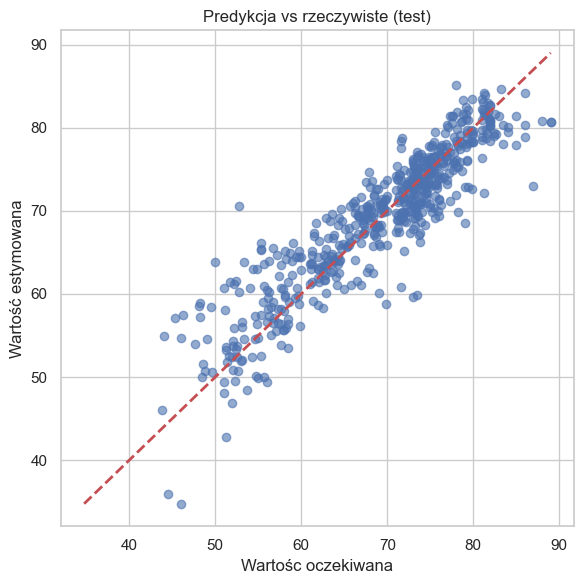

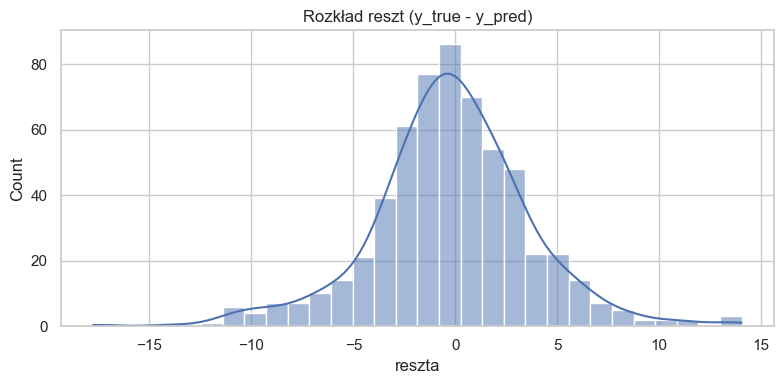

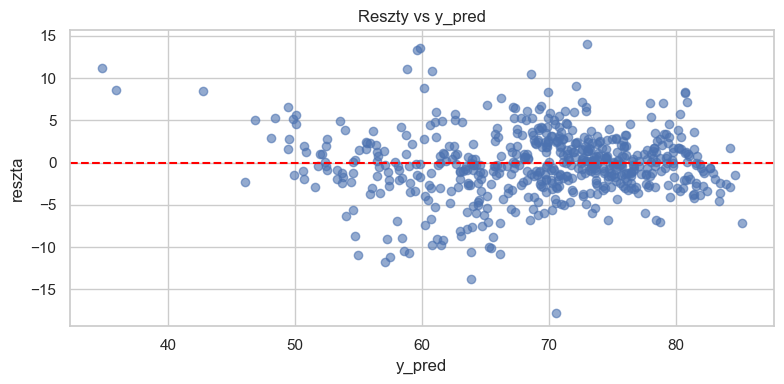

Reszty: średnia= -0.21960721787348692 std= 3.885476331970823


In [49]:
# 11) Wykresy błędów na teście

# 1) Uczymy model na train (po przygotowaniu danych) i przewidujemy na teście
best_model.fit(X_train_t, y_train)
y_pred = best_model.predict(X_test_t)

# 2) Reszty (błędy): dodatnie = model zaniżył, ujemne = model zawyżył
residuals = y_test - y_pred

# Wykres 1: y_true vs y_pred (idealnie punkty leżą na przekątnej)
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
min_v = min(y_test.min(), y_pred.min())
max_v = max(y_test.max(), y_pred.max())
plt.plot([min_v, max_v], [min_v, max_v], "r--", linewidth=2)
plt.xlabel("Wartośc oczekiwana")
plt.ylabel("Wartość estymowana")
plt.title("Predykcja vs rzeczywiste (test)")
plt.tight_layout()
plt.show()

# Wykres 2: rozkład reszt (czy jest symetryczny wokół 0?)
plt.figure(figsize=(8, 4))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Rozkład reszt (y_true - y_pred)")
plt.xlabel("reszta")
plt.tight_layout()
plt.show()

# Wykres 3: reszty vs y_pred (czy błąd zależy od poziomu predykcji?)
plt.figure(figsize=(8, 4))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.title("Reszty vs y_pred")
plt.xlabel("y_pred")
plt.ylabel("reszta")
plt.tight_layout()
plt.show()

print("Reszty: średnia=", float(np.mean(residuals)), "std=", float(np.std(residuals)))

## 12) Ważność cech: współczynniki modelu liniowego

W tej wersji (MED-style) nie robimy permutation importance. Zamiast tego:
- dla modeli liniowych (LinearRegression/Ridge) bierzemy współczynniki `coef_`,
- patrzymy na wartości bezwzględne $|coef|$ i pokazujemy TOP zmiennych.

To jest prosta, czytelna interpretacja – pamiętaj tylko, że dotyczy modelu liniowego i jest sensowna dzięki wcześniejszemu skalowaniu cech numerycznych.

,feature,coef,abs_coef
0,under-five deaths,-11.058112,11.058112
1,infant deaths,10.867040,10.867040
2,Adult Mortality,-2.603276,2.603276
3,HIV/AIDS,-2.423268,2.423268
4,Schooling,2.101076,2.101076
5,Income composition of resources,1.219401,1.219401
6,Diphtheria,0.988764,0.988764
7,Status_Developed,0.833315,0.833315
8,Status_Developing,-0.833315,0.833315
9,BMI,0.816837,0.816837


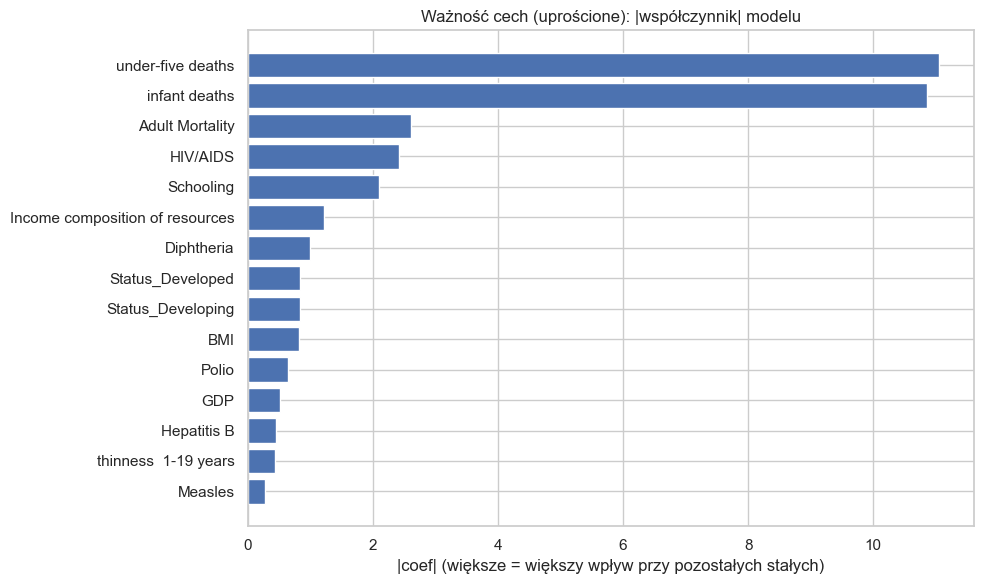

In [47]:
# 12) "Ważność" cech – uproszczone: współczynniki modelu liniowego

# Dla LinearRegression i Ridge mamy współczynniki coef_.
best_model.fit(X_train_t, y_train)

feature_names = np.array(preprocess_bundle.get("feature_names", []), dtype=object)
coefs = np.array(best_model.coef_, dtype=float)

coef_df = (
    pd.DataFrame({
        "feature": feature_names,
        "coef": coefs,
        "abs_coef": np.abs(coefs),
    })
    .sort_values("abs_coef", ascending=False)
    .reset_index(drop=True)
 )

display(coef_df.head(20))

plt.figure(figsize=(10, 6))
topk = coef_df.head(15).iloc[::-1]
plt.barh(topk["feature"], topk["abs_coef"])
plt.title("Ważność cech (uprościone): |współczynnik| modelu")
plt.xlabel("|coef| (większe = większy wpływ przy pozostałych stałych)")
plt.tight_layout()
plt.show()

## 14) Sprawdzenie uogólniania: podział po krajach (Country-holdout)

W danych mamy układ **kraj–rok**. Przy zwykłym losowym podziale wierszy ten sam kraj zwykle trafia i do train, i do test, co może **zawyżać wynik** (model „zna” już ten kraj).

Dlatego robimy prosty test uogólniania:
- losujemy ~80% **krajów** do train, a pozostałe kraje zostają w teście,
- trenujemy model na wierszach z krajów-treningowych,
- sprawdzamy metryki na *innych krajach* (bardziej realistycznie).

Ważne: nadal **nie używamy `Country` jako cechy** — `Country` służy tu tylko do zrobienia podziału.

In [50]:
# 14) Country-holdout – prosty test uogólniania (inne kraje w teście)

# Cel: sprawdzić, czy model działa na "nowych" krajach, a nie tylko na tych, które widział w treningu.
# Uwaga: Country NIE jest cechą modelu – używamy go wyłącznie do podziału danych.

_df = df.copy()
_df.columns = _df.columns.str.strip()

# y (target) jako liczby; wiersze z brakującym y usuwamy (nie da się na nich uczyć/oceniać)
y_all = pd.to_numeric(_df["Life Expectancy"], errors="coerce")
mask = y_all.notna()

# X: cechy bez Country
X_all = _df.drop(columns=["Life Expectancy", "Country"], errors="ignore").loc[mask].reset_index(drop=True)
y_all = y_all.loc[mask].reset_index(drop=True)

# grupa = kraj (potrzebne tylko do podziału)
groups = _df.loc[mask, "Country"].reset_index(drop=True)

# 1) Losujemy kraje do train/test (80/20)
unique_countries = groups.unique()
rng = np.random.RandomState(RANDOM_STATE)
rng.shuffle(unique_countries)

cut = int(0.8 * len(unique_countries))
train_countries = set(unique_countries[:cut])
is_train = groups.isin(train_countries)

# 2) Składamy zbiory na podstawie krajów
X_train_c = X_all.loc[is_train].reset_index(drop=True)
y_train_c = y_all.loc[is_train].reset_index(drop=True)
X_test_c = X_all.loc[~is_train].reset_index(drop=True)
y_test_c = y_all.loc[~is_train].reset_index(drop=True)

print("Country-holdout:")
print("- train rows:", X_train_c.shape, "test rows:", X_test_c.shape)
print("- train countries:", len(train_countries), "test countries:", len(unique_countries) - len(train_countries))

# 3) Przygotowanie danych (tak samo jak w kroku 6, ale dopasowane TYLKO na train_c)
numeric_features_c = X_train_c.select_dtypes(include=["number"]).columns.tolist()
categorical_features_c = [c for c in X_train_c.select_dtypes(include=["object"]).columns.tolist() if c == "Status"]

num_imputer_c = SimpleImputer(strategy="median")
scaler_c = StandardScaler()
cat_imputer_c = SimpleImputer(strategy="most_frequent")
try:
    ohe_c = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe_c = OneHotEncoder(handle_unknown="ignore", sparse=False)

# numeryczne: fit na train, potem transform train/test
X_train_num = scaler_c.fit_transform(num_imputer_c.fit_transform(X_train_c[numeric_features_c]))
X_test_num = scaler_c.transform(num_imputer_c.transform(X_test_c[numeric_features_c]))

# kategoryczne (Status): fit na train, potem transform train/test
if len(categorical_features_c) > 0:
    X_train_cat = ohe_c.fit_transform(cat_imputer_c.fit_transform(X_train_c[categorical_features_c]))
    X_test_cat = ohe_c.transform(cat_imputer_c.transform(X_test_c[categorical_features_c]))
else:
    X_train_cat = np.empty((len(X_train_c), 0))
    X_test_cat = np.empty((len(X_test_c), 0))

X_train_ct = np.hstack([X_train_num, X_train_cat])
X_test_ct = np.hstack([X_test_num, X_test_cat])

# 4) Porównanie modeli na trudniejszym teście (prosto: LinearRegression vs Ridge)
country_results = []
country_results.append(evaluate_estimator(LinearRegression(), X_train_ct, X_test_ct, y_train_c, y_test_c, "LinearRegression"))
country_results.append(evaluate_estimator(Ridge(alpha=1.0, random_state=RANDOM_STATE), X_train_ct, X_test_ct, y_train_c, y_test_c, "Ridge(alpha=1.0)"))

display(pd.DataFrame(country_results).sort_values("RMSE"))

KeyError: 'Life Expectancy'

## 15) Zapis: model + przygotowanie danych 

Zapisujemy bundle z:
- dopasowanymi transformatorami przygotowania danych (`preprocess_bundle`),
- najlepszym modelem (`best_model`).

In [ ]:
# 15) Bundle (model + przygotowanie danych) + przykład predykcji (BEZ zapisu na dysk)

# Zgodnie z wymaganiem: w tym kroku nie tworzymy żadnych dodatkowych plików.
# Bundle trzymamy tylko w pamięci (możesz go ewentualnie zapisać ręcznie w innym miejscu, jeśli będzie potrzebne).

bundle = {
    "preprocess_bundle": preprocess_bundle,
    "model": best_model,
}

# Przykład: predykcja dla kilku wierszy z testu
sample = X_test.head(5)
sample_t = transform_preprocess(bundle["preprocess_bundle"], sample)
preds = bundle["model"].predict(sample_t)

preview = pd.DataFrame({
    "y_true": y_test.loc[sample.index].values,
    "y_pred": preds,
})
preview["abs_error"] = np.abs(preview["y_true"] - preview["y_pred"])
display(preview)

,y_true,y_pred,abs_error
0,73.7,67.141460,6.558540
1,75.9,77.258629,1.358629
2,74.2,75.671570,1.471570
3,76.8,78.093997,1.293997
4,51.9,46.860332,5.039668


## 16) Wnioski do sprawozdania 

- **Wyniki są spójne z EDA**: zależności są w dużej mierze liniowe → modele liniowe osiągają sensowne metryki (dla losowego splitu ok. $R^2\approx 0.83$ i RMSE ok. $3.9$ lat).
- **LinearRegression i Ridge dają bardzo podobne rezultaty**: w tej wersji najlepszy wg RMSE na teście jest `LinearRegression` (RMSE ≈ 3.892), a `Ridge(alpha=1.0)` jest minimalnie gorszy (RMSE ≈ 3.896). Różnice są marginalne, więc regularyzacja nie zmienia tu mocno jakości predykcji.
- **Przygotowanie danych jest kluczowe**: imputacja braków + skalowanie cech numerycznych + One-Hot dla `Status` umożliwia trening bez utraty dużej części danych (która wypadłaby przy `dropna`).
- **Współczynniki modelu** (wartości bezwzględne) pozwalają prosto wskazać, które zmienne najsilniej wpływają na przewidywania w modelu liniowym.
- **Test country-holdout** (inne kraje w teście) jest trudniejszy i pogarsza metryki względem losowego splitu: RMSE rośnie do ok. $4.35$, a $R^2$ spada do ok. $0.80$, co jest typowe dla danych kraj–rok.

## Czemu słaba korelacja, a duża waga?
Korelacja jest jednoczynnikowa.

W regresji patrzymy na wpływ po kontrolowaniu reszty, więc słabo skorelowana cecha może mieć duży współczynnik, zwłaszcza przy współliniowości lub efektach supresji. 


Redukcja do Top10/Top5 pogorszyła RMSE (≈4.00/4.37), LassoCV na pełnym zestawie dało wynik jak baseline (≈3.89), więc lepiej zostawić pełne cechy z lekką regularyzacją.

# DODAŁEM FUNKCJE KTORA POROWNUJE MODEL Z ILOSCIA MNIEJ CECH I JEST NIESTETY GORZEJ :(

In [82]:
num_imputer = globals().get("num_imputer_used", SimpleImputer(strategy="median"))
scaler = globals().get("scaler_used", StandardScaler())
cat_imputer = globals().get("cat_imputer_used", SimpleImputer(strategy="most_frequent"))
try:
    ohe = ohe_used
except NameError:
    try:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

num_pipe = Pipeline([("imputer", num_imputer), ("scaler", scaler)])
cat_pipe = Pipeline([("imputer", cat_imputer), ("ohe", ohe)])

results, models = [], {}

def run(model, nums, name):
    prep = ColumnTransformer([("num", num_pipe, nums), ("cat", cat_pipe, cat_cols)], remainder="drop")
    pipe = Pipeline([("preprocess", prep), ("model", model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    results.append({"model": name, "rmse": mean_squared_error(y_test, preds, squared=False), "r2": r2_score(y_test, preds)})
    models[name] = pipe

run(LinearRegression(), corr_abs_sorted.index[:10].tolist(), "Top10+cat OLS")
run(LinearRegression(), corr_abs_sorted.index[:5].tolist(), "Top5+cat OLS")

prep_all = ColumnTransformer([("num", num_pipe, num_cols), ("cat", cat_pipe, cat_cols)], remainder="drop")
lasso_cv = LassoCV(alphas=np.logspace(-3, 1, 15), cv=5, random_state=RANDOM_STATE, max_iter=20000)
lasso_pipe = Pipeline([("preprocess", prep_all), ("model", lasso_cv)])
lasso_pipe.fit(X_train, y_train)
lasso_preds = lasso_pipe.predict(X_test)
results.append({"model": "LassoCV all", "rmse": mean_squared_error(y_test, lasso_preds, squared=False), "r2": r2_score(y_test, lasso_preds), "alpha": lasso_pipe.named_steps["model"].alpha_})
models["LassoCV all"] = lasso_pipe

try:
    base_preds = best_model.predict(X_test_t)
    results.append({"model": "Baseline (all features, best_model)", "rmse": mean_squared_error(y_test, base_preds, squared=False), "r2": r2_score(y_test, base_preds)})
except Exception:
    pass

results_red_df = pd.DataFrame(results).sort_values("rmse")
display(results_red_df)

lasso_coefs = lasso_pipe.named_steps["model"].coef_
lasso_features = lasso_pipe.named_steps["preprocess"].get_feature_names_out()
lasso_keep = pd.DataFrame({"feature": lasso_features, "coef": lasso_coefs})
lasso_keep = lasso_keep[lasso_keep["coef"] != 0].sort_values("coef", key=np.abs, ascending=False)
print("\nCechy zachowane przez Lasso (|coef|>0):")
display(lasso_keep.head(20))

NameError: name 'Pipeline' is not defined